In [1]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1488/1488), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 13187 (delta 1166), reused 1220 (delta 1100), pack-reused 11699 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (9972/9972), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793130 sha256=063b1e851afcc778b6e031fc4716a9b884eeb02b9b2040050b6abf41fdec13d2
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import gym
from torch.nn import functional as F
import math
import neurogym as ngym
import torch.nn.init as init
import scipy.spatial
plt.rcParams['font.family'] = 'DejaVu Sans'

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [3]:
import torch
import torch.nn as nn

class LeakyRNNMultiTask(nn.Module):
    """Leaky RNN with multiple task-specific output layers."""
    def __init__(self, input_size, hidden_size, output_sizes, dt=None):
        """
        Parameters:
            input_size: int, input size
            hidden_size: int, hidden layer size
            output_sizes: list of int, output sizes for each task
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        self.alpha = dt / self.tau if dt else 1

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)


        self.task_heads = nn.ModuleList([nn.Linear(hidden_size, out_size) for out_size in output_sizes])

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Run network for one time step."""
        state, output = hidden
        h_new = torch.relu(self.input2h(input) + self.h2h(output))
        state = state * (1 - self.alpha) + h_new * self.alpha
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None, task_id=0):
        """
        Parameters:
            input: tensor of shape (seq_len, batch, input_size)
            hidden: initial hidden state
            task_id: int, identifies the task

        Returns:
            out: tensor of shape (seq_len, batch, output_sizes[task_id])
            hidden: final hidden state
        """
        if hidden is None:
            hidden = self.init_hidden(input)

        outputs = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            outputs.append(hidden[1])
        rnn_output = torch.stack(outputs, dim=0)


        out = self.task_heads[task_id](rnn_output)
        return out, hidden


class RNNNetMultiTask(nn.Module):
    """Wrapper for Leaky RNN with task-specific heads."""
    def __init__(self, input_size, hidden_size, output_sizes, dt=None):
        """
        Parameters:
            input_size: int, input size
            hidden_size: int, hidden layer size
            output_sizes: list of int, output sizes for each task
        """
        super().__init__()
        self.rnn = LeakyRNNMultiTask(input_size, hidden_size, output_sizes, dt)

    def forward(self, x, task_id):
        """
        Parameters:
            x: tensor of shape (seq_len, batch, input_size)
            task_id: int, identifies the task being trained/inferred

        Returns:
            out: tensor of shape (seq_len, batch, output_sizes[task_id])
            rnn_output: tensor of shape (seq_len, batch, hidden_size)
        """
        out, hidden = self.rnn(x, task_id=task_id)
        return out, hidden

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
class LeakyRNNMultiTask(nn.Module):
    """Leaky RNN with multiple task-specific output layers."""
    def __init__(self, input_size, hidden_size, output_sizes, dt=None):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        self.alpha = dt / self.tau if dt else 1

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)


        self.task_heads = nn.ModuleList([nn.Linear(hidden_size, out_size) for out_size in output_sizes])

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Run network for one time step."""
        state, output = hidden
        h_new = torch.relu(self.input2h(input) + self.h2h(output))
        state = state * (1 - self.alpha) + h_new * self.alpha
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None, task_id=0):
        """
        Parameters:
            input: tensor of shape (seq_len, batch, input_size)
            hidden: initial hidden state
            task_id: int, identifies the task

        Returns:
            out: tensor of shape (seq_len, batch, output_sizes[task_id])
            rnn_output: tensor of shape (seq_len, batch, hidden_size)
        """
        if hidden is None:
            hidden = self.init_hidden(input)

        outputs = []
        hidden_states = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            hidden_states.append(hidden[1])
            outputs.append(hidden[1])

        rnn_output = torch.stack(hidden_states, dim=0)
        out = self.task_heads[task_id](torch.stack(outputs, dim=0))
        return out, rnn_output
class RNNNetMultiTask(nn.Module):
    """Wrapper for Leaky RNN with task-specific heads."""
    def __init__(self, input_size, hidden_size, output_sizes, dt=None):
        """
        Parameters:
            input_size: int, input size
            hidden_size: int, hidden layer size
            output_sizes: list of int, output sizes for each task
        """
        super().__init__()
        self.rnn = LeakyRNNMultiTask(input_size, hidden_size, output_sizes, dt)

    def forward(self, x, task_id):
        """
        Parameters:
            x: tensor of shape (seq_len, batch, input_size)
            task_id: int, identifies the task being trained/inferred

        Returns:
            out: tensor of shape (seq_len, batch, output_sizes[task_id])
            rnn_output: tensor of shape (seq_len, batch, hidden_size)
        """
        out, rnn_output = self.rnn(x, task_id=task_id)
        return out, rnn_output

In [8]:
%%capture
# @title import the task from the neurogym library

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task0 = 'PerceptualDecisionMaking-v0'
task1 = 'GoNogo-v0'
#task = 'Bandit-v0'
#task = 'ReadySetGo-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset0 = ngym.Dataset(task0, env_kwargs=kwargs, batch_size=1,
                       seq_len=seq_len)

dataset1 = ngym.Dataset(task1, env_kwargs=kwargs, batch_size=1,
                       seq_len=seq_len)

# A sample environment from dataset
env0 = dataset0.env
env1 = dataset1.env

# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env1, num_trials=2)

# Network input and output size
input_size1 = env1.observation_space.shape[0]
output_size1 = env1.action_space.n

input_size0 = env0.observation_space.shape[0]
output_size0 = env0.action_space.n

print(input_size0)
print(input_size1)

print(output_size0)
print(output_size1)

Step 200, Task 0, Loss: 0.5996
Step 200, Task 1, Loss: 0.4405
Step 400, Task 0, Loss: 0.4605
Step 400, Task 1, Loss: 0.3152
Step 600, Task 0, Loss: 0.3904
Step 600, Task 1, Loss: 0.2877
Step 800, Task 0, Loss: 0.3240
Step 800, Task 1, Loss: 0.2182
Step 1000, Task 0, Loss: 0.2885
Step 1000, Task 1, Loss: 0.1571
Step 1200, Task 0, Loss: 0.2562
Step 1200, Task 1, Loss: 0.1424
Step 1400, Task 0, Loss: 0.2316
Step 1400, Task 1, Loss: 0.1516
Step 1600, Task 0, Loss: 0.1853
Step 1600, Task 1, Loss: 0.1248
Step 1800, Task 0, Loss: 0.1692
Step 1800, Task 1, Loss: 0.1245
Step 2000, Task 0, Loss: 0.1737
Step 2000, Task 1, Loss: 0.1452


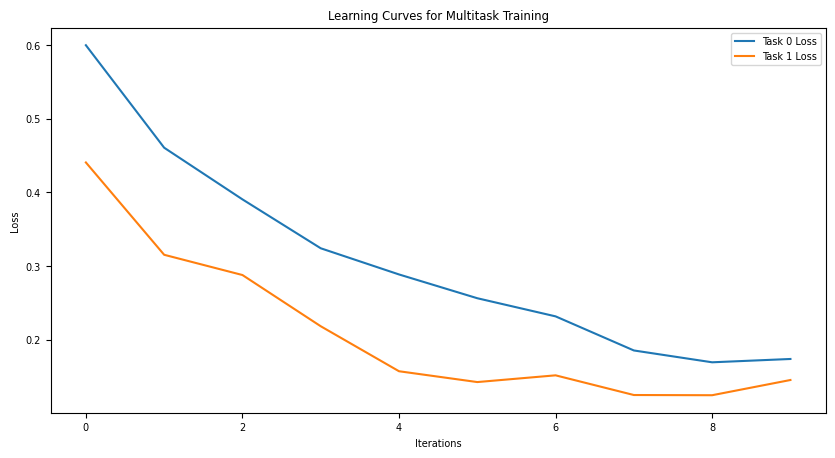

In [9]:
import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

# Initialize the model
hidden_size = 50
output_sizes = [3, 2]  # Task 0: 3 classes, Task 1: 2 classes
net = RNNNetMultiTask(input_size=input_size0, hidden_size=hidden_size,
                      output_sizes=output_sizes, dt=env0.dt)

# Define optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Alternate datasets
datasets = [dataset0, dataset1]


task_losses = {0: [], 1: []}
running_loss = {0: 0.0, 1: 0.0}

# Training parameters
num_iterations = 2000
print_step = 200  # How often to print and log average loss

# Training loop
for i in range(num_iterations):
    # Select the task (alternate or randomize)
    task_id = i % 2  # Alternates tasks; replace with random.choice([0, 1]) for randomness
    dataset = datasets[task_id]

    # Fetch inputs and labels for the current task
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, _ = net(inputs, task_id=task_id)
    output = output.view(-1, output_sizes[task_id])  # Adjust output size for the task

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update model parameters
    optimizer.step()

    # Update running loss for the current task
    running_loss[task_id] += loss.item()

    # Log and reset running loss every print_step
    if (i + 1) % print_step == 0:
        for tid in [0, 1]:
            average_loss = running_loss[tid] / (print_step // 2)
            print(f"Step {i+1}, Task {tid}, Loss: {average_loss:.4f}")
            task_losses[tid].append(average_loss)
            running_loss[tid] = 0.0

# Plot the learning curves for both tasks
plt.figure(figsize=(10, 5))
plt.plot(task_losses[0], label='Task 0 Loss')
plt.plot(task_losses[1], label='Task 1 Loss')
plt.title("Learning Curves for Multitask Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [17]:
# Initialize task-specific environments
tasks = [env0, env1]  # Task 0 and Task 1 environments
num_trials = 500
perf = {0: 0, 1: 0}  # Store performance for each task
trial_infos = {0: {}, 1: {}}  # Store trial information for each task

# Loop through each task
for task_id, env in enumerate(tasks):
    # Reset and configure the environment for the task
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500),
                       'stimulus': ('constant', 500)})

    for i in range(num_trials):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

        # Forward pass through the network with the task ID
        action_pred, _ = net(inputs, task_id=task_id)  # Only use the output predictions

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])  # Take the last time step prediction
        correct = choice == gt[-1]
        perf[task_id] += int(correct)

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[task_id][i] = trial_info

# Calculate average performance for each task
for task_id in range(len(tasks)):
    avg_perf = perf[task_id] / num_trials
    print(f"Average performance for Task {task_id}: {avg_perf:.4f}")

Average performance for Task 0: 0.7460
Average performance for Task 1: 1.0000


In [22]:
perf = 0
num_trial = 500
activity_dict = {}  # Hidden layer activity for all trials
trial_infos = {}    # Information about each trial
stim_activity = [[], []]  # Response for ground-truth 0 and 1

for i in range(num_trial):
    # Alternate between tasks
    env = env0 if i % 2 == 0 else env1  # Task alternation
    task_id = 0 if i % 2 == 0 else 1  # Assign task ID

    # Generate a new trial
    env.new_trial()
    ob, gt = env.ob, env.gt  # Observations and ground truth
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Forward pass through the model
    action_pred, rnn_activity = net(inputs, task_id=task_id)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])  # Use last time step prediction
    correct = choice == gt[-1]
    perf += int(correct)

    # Log trial info with task ID
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice, 'task_id': task_id})
    trial_infos[i] = trial_info

    # Log hidden layer activity for the trial
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

Shape of the neural activity (Time points, Neurons): (27810, 50)
Shape of the projected activity (Time points, PCs): (27810, 2)


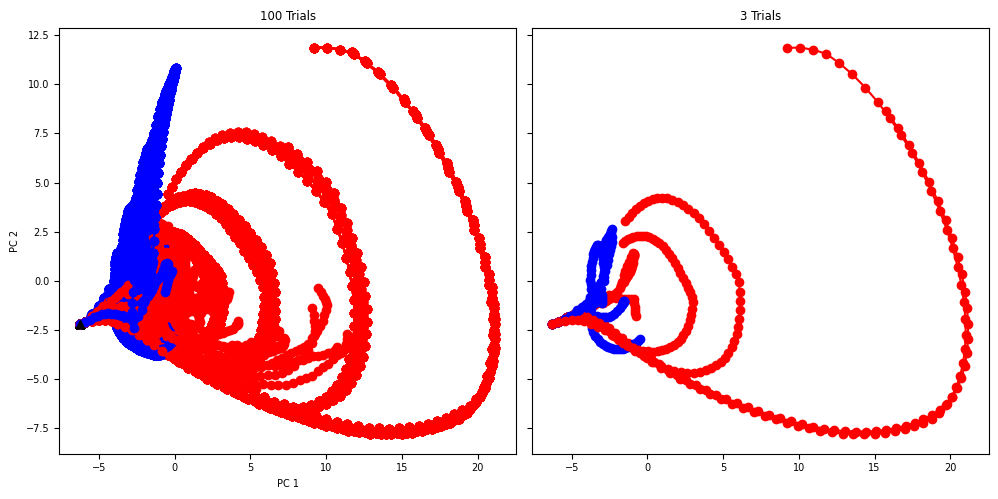

In [11]:
from sklearn.decomposition import PCA

import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyze

# Adjust the time limit for plotting
plot_until_time = 70

# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(500):
    # Transform and plot each trial
    activity_pc_trial = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)
    if i < 10:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc_trial[0, 0], activity_pc_trial[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

Task 0 PCA shape: (13750, 2)
Task 1 PCA shape: (25000, 2)


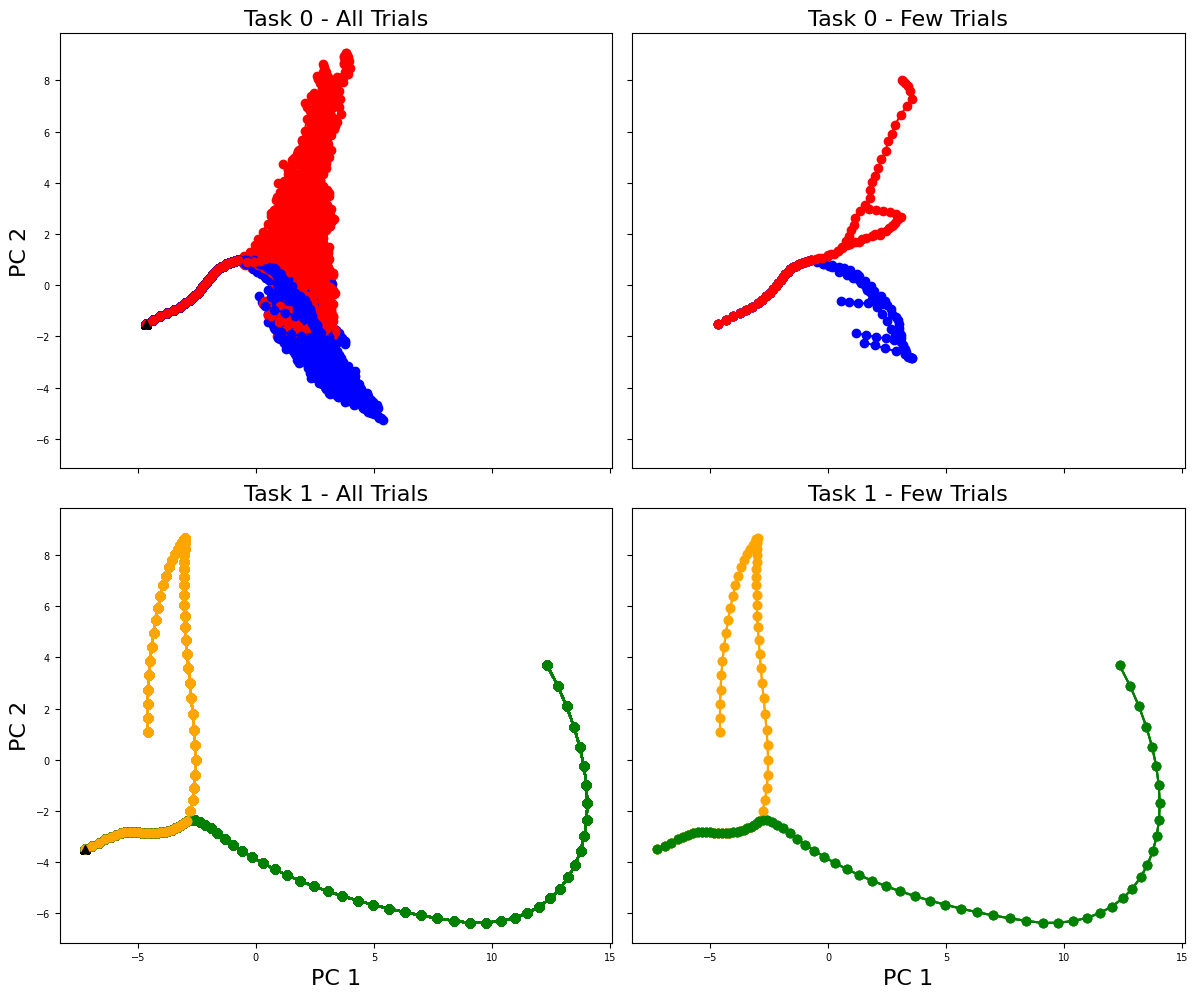

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyze
plot_until_time = 70  # Adjust the time limit for plotting

# Separate activity data for each task ID
activity_task0 = np.concatenate([activity_dict[i] for i in range(num_trial) if trial_infos[i]['task_id'] == 0], axis=0)
activity_task1 = np.concatenate([activity_dict[i] for i in range(num_trial) if trial_infos[i]['task_id'] == 1], axis=0)

# Perform PCA separately for each task
pca_task0 = PCA(n_components=2)  # Task 0 PCA
pca_task0.fit(activity_task0)
activity_pc_task0 = pca_task0.transform(activity_task0)

pca_task1 = PCA(n_components=2)  # Task 1 PCA
pca_task1.fit(activity_task1)
activity_pc_task1 = pca_task1.transform(activity_task1)

print('Task 0 PCA shape:', activity_pc_task0.shape)
print('Task 1 PCA shape:', activity_pc_task1.shape)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes


for i in range(num_trial):
    if trial_infos[i]['task_id'] == 0:
        activity_pc_trial = pca_task0.transform(activity_dict[i])
        trial = trial_infos[i]
        color = 'red' if trial['ground_truth'] == 0 else 'blue'
        ax1.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)
        if i < 10:
            ax2.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)
        ax1.plot(activity_pc_trial[0, 0], activity_pc_trial[0, 1], '^', color='black')


for i in range(num_trial):
    if trial_infos[i]['task_id'] == 1:
        activity_pc_trial = pca_task1.transform(activity_dict[i])
        trial = trial_infos[i]
        color = 'green' if trial['ground_truth'] == 0 else 'orange'
        ax3.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)
        if i < 10:
            ax4.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)
        ax3.plot(activity_pc_trial[0, 0], activity_pc_trial[0, 1], '^', color='black')

# Add labels and titles
ax1.set_title('Task 0 - All Trials',fontsize = 16)
ax2.set_title('Task 0 - Few Trials',fontsize = 16)
ax3.set_title('Task 1 - All Trials',fontsize = 16)
ax4.set_title('Task 1 - Few Trials',fontsize = 16)

for ax in [ax1, ax3]:
    ax.set_ylabel('PC 2',fontsize = 16)
for ax in [ax3, ax4]:
    ax.set_xlabel('PC 1',fontsize = 16)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Network connectivity')

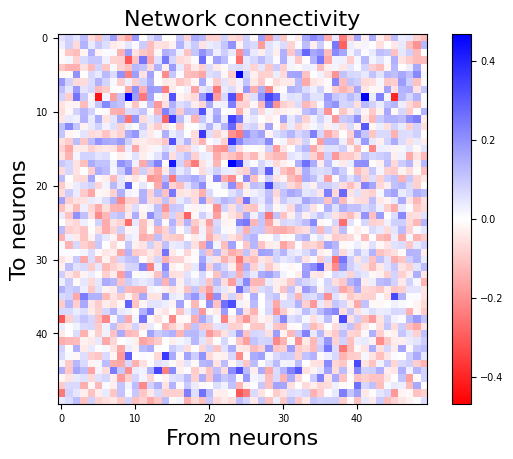

In [24]:
W = net.rnn.h2h.weight.detach().cpu().numpy()
# Sort by selectivity
#W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons',fontsize=16)
plt.ylabel('To neurons',fontsize=16)
plt.title('Network connectivity',fontsize=16)